In [95]:
import pandas as pd
import ast
from tqdm import tqdm

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import ParameterGrid

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

import matplotlib.pyplot as plt

### 1. Load Data

In [80]:
count_df = pd.read_csv("../data/processed_text/bigrams_count_11_23.csv")
count_df.head()

,aa,aaa,aapi,ab,abandoned,abandoned_foreclosed,abandoned_railroad,abandoning,abandonment,abate,...,zero_carbon,zika,zip,zone,zoned,zoned_primarily,zoning,zoning_framework,zora,zz
0,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
text_df = pd.read_csv("../data/processed_text/text_df_11_23.csv")

text_df["bigrams"] = text_df["bigrams"].apply(ast.literal_eval) # turn back into lists
text_df["tokens"] = text_df["tokens"].apply(ast.literal_eval) # turn back into lists

text_df.head()

,congress,bill_id,original_text,cleaned_text,tokens,bigrams,bigrams_str
0,110,110-hr1752,[Congressional Bills 110th Congress] [From the...,a bill to modernize and update the national ho...,"[modernize, update, national, housing, enable,...","[modernize, update, national, housing, enable,...",modernize update national housing enable feder...
1,110,110-hr1999,[Congressional Bills 110th Congress] [From the...,a bill to authorize appropriations for assista...,"[authorize, appropriation, assistance, nationa...","[authorize, appropriation, assistance, nationa...",authorize appropriation assistance national co...
2,110,110-s1386,[Congressional Bills 110th Congress] [From the...,a bill to amend the housing and urban developm...,"[housing, urban, development, provide, better,...","[housing, urban, development, provide, better,...",housing urban development provide better assis...
3,110,110-hr1227,[Congressional Bills 110th Congress] [From the...,an act to assist in the provision of affordabl...,"[assist, provision, affordable, housing, low, ...","[assist, provision, affordable, housing, low, ...",assist provision affordable housing low income...
4,110,110-hr1515,[Congressional Bills 110th Congress] [From the...,an act to amend the housing and community deve...,"[housing, community, development, treat, certa...","[housing, community, development, treat, certa...",housing community development treat certain co...


In [ ]:
# tokens

token_list = text_df["tokens"].tolist()
token_dict = corpora.Dictionary(token_list) # create Gensim dict obj

token_corpus = [token_dict.doc2bow(tex st) for text in token_list] # create Gensim corpus obj

####################################################################################################

# bigrams

bigram_list = text_df["bigrams"].tolist()
bigram_dict = corpora.Dictionary(bigram_list) # create Gensim dict obj

bigram_corpus = [bigram_dict.doc2bow(text) for text in bigram_list] # create Gensim corpus obj

### 2. Parameter Tuning

#### Number of Topics

In [102]:
def plot_topic_validation(topic_range, text_list, corpus, dictionary):

    coherences = []
    perplexities = []

    for k in tqdm(topic_range):
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            passes=10,
            random_state=42
        )
        
        # Coherence
        cm = CoherenceModel(model=lda, texts=text_list, dictionary=dictionary, coherence='c_v')
        coherences.append(cm.get_coherence())
        
        # Perplexity
        log_perplexity = lda.log_perplexity(corpus)
        perplexities.append(log_perplexity)  # convert to standard perplexity

    # Plot
    fig, ax1 = plt.subplots(figsize=(10,6))

    color = 'tab:blue'
    ax1.set_xlabel("Number of Topics")
    ax1.set_ylabel("Coherence (c_v)", color=color)
    ax1.plot(topic_range, coherences, marker='o', color=color, label='Coherence')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 
    color = 'tab:red'
    ax2.set_ylabel("Perplexity", color=color)
    ax2.plot(topic_range, perplexities, marker='x', color=color, label='Perplexity')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("LDA Coherence and Perplexity vs Number of Topics")
    plt.show()

100%|██████████| 20/20 [15:53<00:00, 47.67s/it]


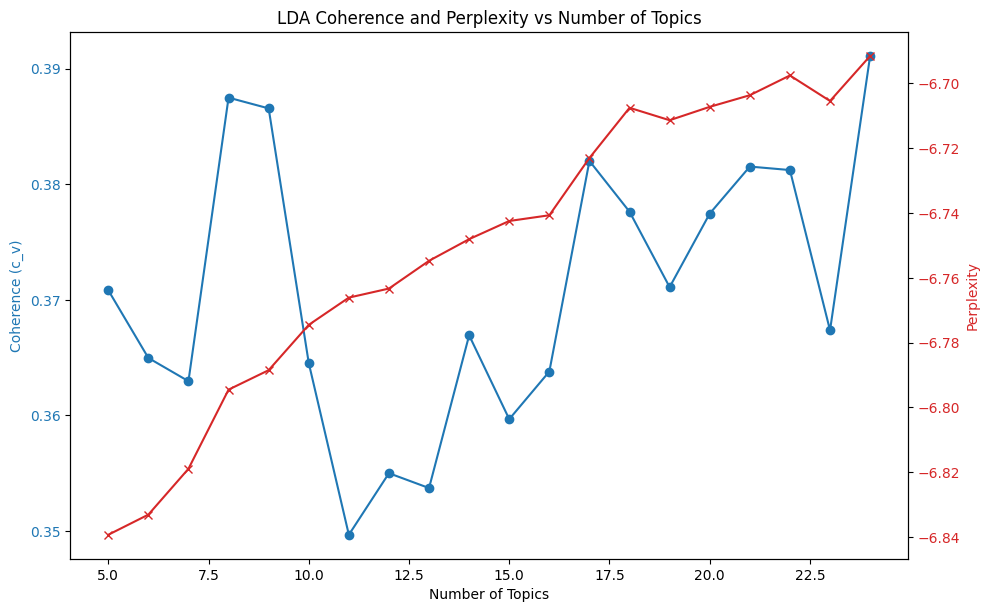

In [104]:
topic_range = range(5, 25, 1)

plot_topic_validation(topic_range=topic_range, text_list=bigram_list, corpus=bigram_corpus, dictionary=bigram_dict)

100%|██████████| 20/20 [16:48<00:00, 50.42s/it]


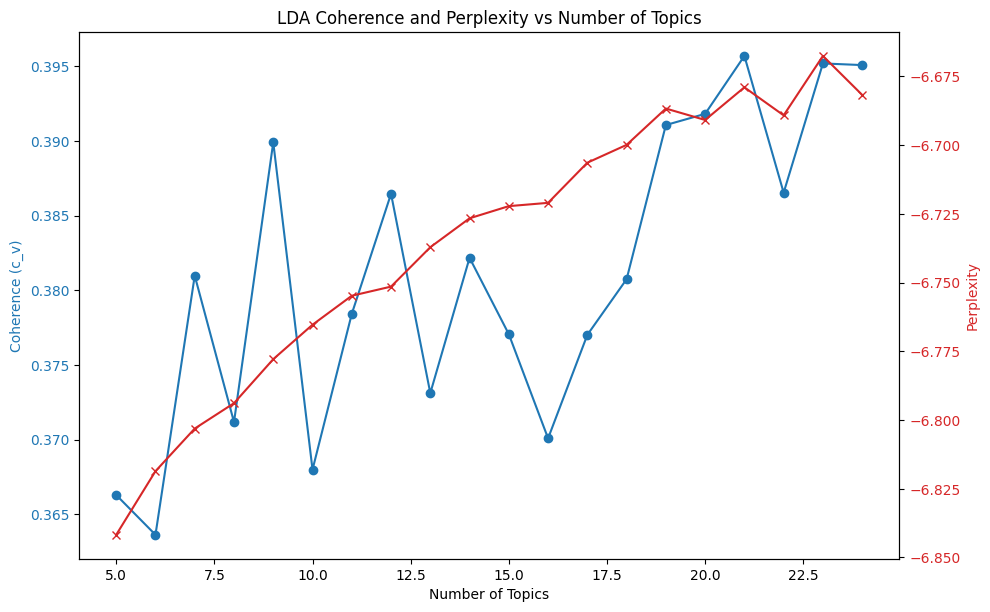

In [ ]:
plot_topic_validation(topic_range=topic_range, text_list=token_list, corpus=token_corpus, dictionary=token_dict)

### 2. Baseline LDA Model (Gensim)

In [108]:
# Hyperparameters
num_topics = 9
passes = 10          # number of iterations over the corpus
random_state = 42    # reproducibility
alpha = 'auto'       # document-topic prior
eta = 'auto'         # topic-word prior

# Train LDA
lda = LdaModel(
    corpus=bigram_corpus,
    id2word=bigram_dict,
    num_topics=num_topics,
    passes=passes,
    random_state=random_state,
    alpha=alpha,
    eta=eta
)


In [109]:
for i, topic in lda.show_topics(num_topics=num_topics, num_words=15, formatted=False):
    words = [w for w, prob in topic]
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: housing, public, agency, program, project, assistance, unit, amount, development, term, state, grant, cost, dwelling, assisted
Topic 1: housing, state, grant, eligible, term, home, unit, community, development, affordable, entity, program, income, federal, local
Topic 2: housing, assistance, grant, program, state, amount, development, fund, community, homeless, term, eligible, entity, available, individual
Topic 3: housing, public, agency, program, family, assistance, unit, resident, service, state, tenant, grant, united, eligible, assisted
Topic 4: grant, program, project, state, eligible, local, loan, term, entity, community, federal, development, government, including, plan
Topic 5: loan, mortgage, term, borrower, property, housing, federal, financial, servicer, home, program, covered, interest, foreclosure, date
Topic 6: housing, year, amount, project, credit, assistance, rental, income, term, qualified, state, loan, building, program, eligible
Topic 7: mortgage, housing, 

In [113]:
lda.alpha

array([0.06061402, 0.06782275, 0.09454933, 0.07728572, 0.05210951,
       0.05464502, 0.0553212 , 0.06131588, 0.05753483], dtype=float32)